In [7]:
import os
import json
import re
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.linear_model import LogisticRegression

In [8]:
# get regex from file names
def extract_numbers(filename):
    return list(map(int, re.findall(r'\d+', filename)))

In [9]:
def get_feature_scores(solution_path):
    total_files = sum(len(files) for _, _, files in os.walk(solution_path))

    all_feature_scores = np.zeros((total_files, 5))
    idx = 0

    for problem_dir in sorted(os.listdir(solution_path)):
        print(f"Processing directory: {problem_dir}")
        problem_dir_path = os.path.join(solution_path, problem_dir)

        if os.path.isdir(problem_dir_path):
            # iterate over every file in the problem directory
            for json_file_name in sorted(os.listdir(problem_dir_path), key=extract_numbers):
                json_file_path = os.path.join(problem_dir_path, json_file_name)

                # retrieve feature scores from the solution files
                with open(json_file_path, 'r') as json_file:
                    data = json.load(json_file)
                    feature_scores = [data[f'feature{i+1}']['score'] for i in range(5)]
                    all_feature_scores[idx] = feature_scores

                idx += 1

    return all_feature_scores

In [10]:
def get_labels(solution_path, label_path):
    all_labels = []

    for problem_dir in sorted(os.listdir(solution_path)):
        print(f"Processing directory: {problem_dir}")
        problem_dir_path = os.path.join(solution_path, problem_dir)

        if os.path.isdir(problem_dir_path):
            # retrieve the corresponding truth file path
            truth_file_path = os.path.join(label_path, f'truth-{problem_dir}.json')

            # read the truth file
            with open(truth_file_path, 'r') as truth_file:
                truth_data = json.load(truth_file)
                changes = truth_data['changes']

            # iterate over every file in the problem directory
            for json_file_name in sorted(os.listdir(problem_dir_path), key=extract_numbers):
                # retrieve the label
                label_index = extract_numbers(json_file_name)[0] - 1  # 假设索引从0开始
                label = changes[label_index]
                all_labels.append(label)
                
    all_labels = np.array(all_labels)
    all_labels = np.ones_like(all_labels) - all_labels

    return all_labels

In [11]:
def iterate_thresholds(thresholds, scores, labels):
    accuracy_list = []
    f1_list = []
    
    for threshold in thresholds:
        predicted_labels = (scores >= threshold).astype(int)

        accuracy = accuracy_score(labels, predicted_labels)
        f1 = f1_score(labels, predicted_labels, average = 'macro', labels = [0, 1], zero_division = 0)

        accuracy_list.append(accuracy)
        f1_list.append(f1)
    
    return accuracy_list, f1_list

## Evaluate on the Training Set

In [12]:
all_feature_scores = get_feature_scores('data/train_solution')
all_labels = get_labels('data/train_solution', 'data/train_label')

Processing directory: problem-1
Processing directory: problem-10
Processing directory: problem-100
Processing directory: problem-1000
Processing directory: problem-1001
Processing directory: problem-1002
Processing directory: problem-1003
Processing directory: problem-1004
Processing directory: problem-1005
Processing directory: problem-1006
Processing directory: problem-1007
Processing directory: problem-1008
Processing directory: problem-1009
Processing directory: problem-101
Processing directory: problem-1010
Processing directory: problem-1011
Processing directory: problem-1012
Processing directory: problem-1013
Processing directory: problem-1014
Processing directory: problem-1015
Processing directory: problem-1016
Processing directory: problem-1017
Processing directory: problem-1018
Processing directory: problem-1019
Processing directory: problem-102
Processing directory: problem-1020
Processing directory: problem-1021
Processing directory: problem-1022
Processing directory: proble

In [13]:
all_feature_scores.shape, all_labels.shape

((21913, 5), (21913,))

In [14]:
np.sum(all_labels == 0), np.sum(all_labels == 1)

(12493, 9420)

### Average Scores as Overall Scores

In [33]:
overall_scores = np.mean(all_feature_scores, axis = 1)

thresholds = np.arange(0.1, 1.0, 0.1)
accuracy_list, f1_list = iterate_thresholds(thresholds, overall_scores, all_labels)

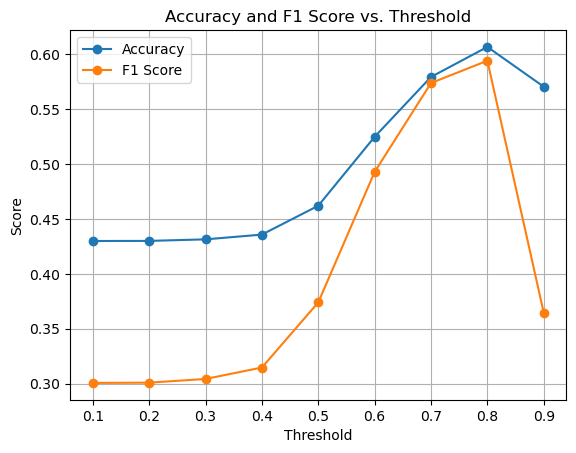

In [34]:
plt.plot(thresholds, accuracy_list, label='Accuracy', marker='o')
plt.plot(thresholds, f1_list, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Accuracy and F1 Score vs. Threshold')
plt.legend()
plt.grid(True)

### Feature Scores

In [17]:
feature_accuracy_list = []
feature_f1_list = []

thresholds = np.arange(0.1, 1.0, 0.1)

for i in range(all_feature_scores.shape[1]):
    feature_accuracy, feature_f1 = iterate_thresholds(thresholds, all_feature_scores[:, i], all_labels)
    feature_accuracy_list.append(feature_accuracy)
    feature_f1_list.append(feature_f1)

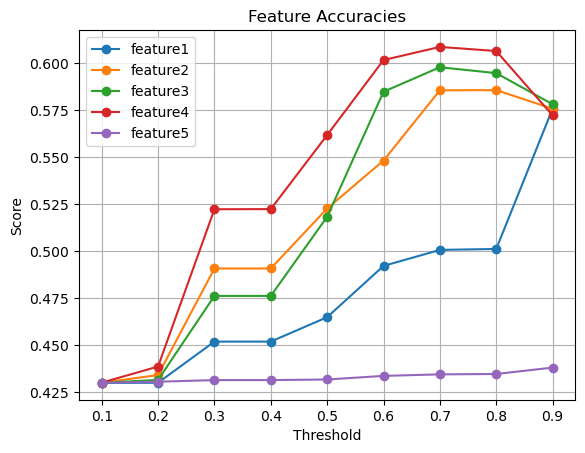

In [18]:
for i in range(all_feature_scores.shape[1]):
    plt.plot(thresholds, feature_accuracy_list[i], label = f'feature{i+1}', marker = 'o')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title(f'Feature Accuracies')
plt.legend()
plt.grid(True)

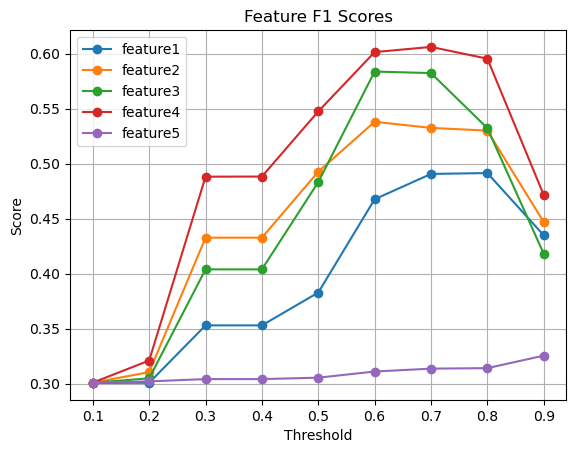

In [19]:
for i in range(all_feature_scores.shape[1]):
    plt.plot(thresholds, feature_f1_list[i], label = f'feature{i+1}', marker = 'o')

plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title(f'Feature F1 Scores')
plt.legend()
plt.grid(True)

### Scores with CoT Prompt

In [20]:
cot_solution_path = 'data/train_solution_cot'
all_cot_scores = []

for problem_dir in sorted(os.listdir(cot_solution_path)):
    print(f"Processing directory: {problem_dir}")
    problem_dir_path = os.path.join(cot_solution_path, problem_dir)
        
    for json_file_name in sorted(os.listdir(problem_dir_path), key=extract_numbers):
        json_file_path = os.path.join(problem_dir_path, json_file_name)
        
        with open(json_file_path, 'r') as json_file:
            data = json.load(json_file)
            score = data['score']
            all_cot_scores.append(score)

all_cot_scores = np.array(all_cot_scores)

Processing directory: problem-1
Processing directory: problem-10
Processing directory: problem-100
Processing directory: problem-1000
Processing directory: problem-1001
Processing directory: problem-1002
Processing directory: problem-1003
Processing directory: problem-1004
Processing directory: problem-1005
Processing directory: problem-1006
Processing directory: problem-1007
Processing directory: problem-1008
Processing directory: problem-1009
Processing directory: problem-101
Processing directory: problem-1010
Processing directory: problem-1011
Processing directory: problem-1012
Processing directory: problem-1013
Processing directory: problem-1014
Processing directory: problem-1015
Processing directory: problem-1016
Processing directory: problem-1017
Processing directory: problem-1018
Processing directory: problem-1019
Processing directory: problem-102
Processing directory: problem-1020
Processing directory: problem-1021
Processing directory: problem-1022
Processing directory: proble

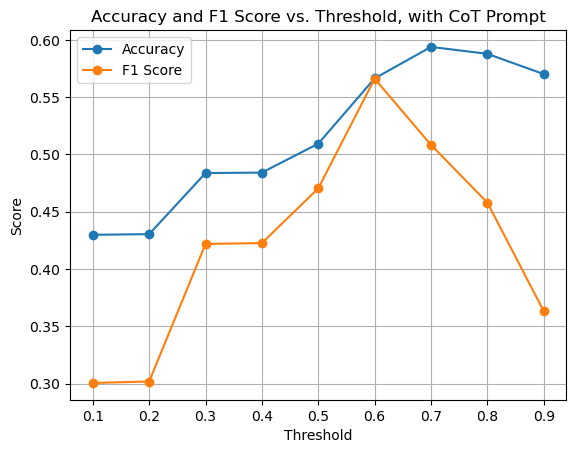

In [21]:
thresholds = np.arange(0.1, 1.0, 0.1)
cot_accuracy_list, cot_f1_list = iterate_thresholds(thresholds, all_cot_scores, all_labels)

plt.plot(thresholds, cot_accuracy_list, label='Accuracy', marker='o')
plt.plot(thresholds, cot_f1_list, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Accuracy and F1 Score vs. Threshold, with CoT Prompt')
plt.legend()
plt.grid(True)

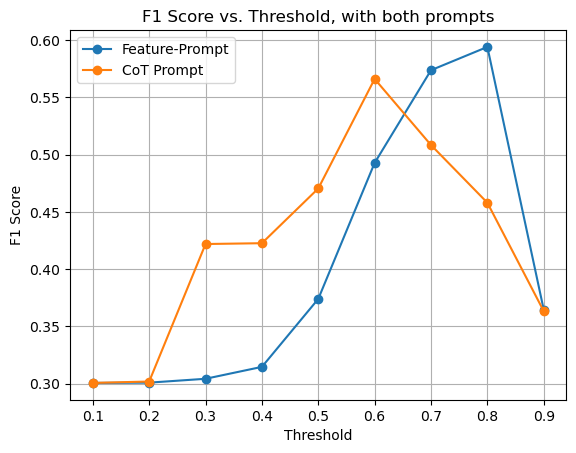

In [35]:
plt.plot(thresholds, f1_list, label='Feature-Prompt', marker='o')
plt.plot(thresholds, cot_f1_list, label='CoT Prompt', marker='o')
plt.xlabel('Threshold')
plt.ylabel('F1 Score')
plt.title('F1 Score vs. Threshold, with both prompts')
plt.legend()
plt.grid(True)

## Evaluate on Validation Set

In [22]:
all_val_feature_scores = get_feature_scores('data/validation_solution')
all_val_labels = get_labels('data/validation_solution', 'data/validation_label')

Processing directory: problem-1
Processing directory: problem-10
Processing directory: problem-100
Processing directory: problem-101
Processing directory: problem-102
Processing directory: problem-103
Processing directory: problem-104
Processing directory: problem-105
Processing directory: problem-106
Processing directory: problem-107
Processing directory: problem-108
Processing directory: problem-109
Processing directory: problem-11
Processing directory: problem-110
Processing directory: problem-111
Processing directory: problem-112
Processing directory: problem-113
Processing directory: problem-114
Processing directory: problem-115
Processing directory: problem-116
Processing directory: problem-117
Processing directory: problem-118
Processing directory: problem-119
Processing directory: problem-12
Processing directory: problem-120
Processing directory: problem-121
Processing directory: problem-122
Processing directory: problem-123
Processing directory: problem-124
Processing director

In [23]:
all_val_feature_scores.shape, all_val_labels.shape

((4592, 5), (4592,))

In [24]:
np.sum(all_val_labels == 0), np.sum(all_val_labels == 1)

(2603, 1989)

In [25]:
val_overall_scores = np.mean(all_val_feature_scores, axis = 1)

thresholds = np.arange(0.1, 1.0, 0.1)
val_accuracy_list, val_f1_list = iterate_thresholds(thresholds, val_overall_scores, all_val_labels)

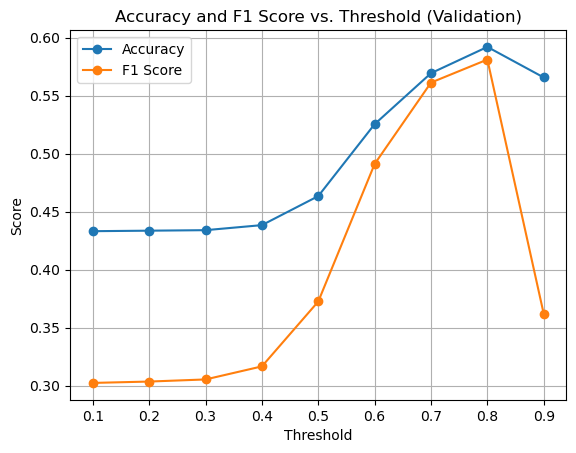

In [26]:
plt.plot(thresholds, val_accuracy_list, label='Accuracy', marker='o')
plt.plot(thresholds, val_f1_list, label='F1 Score', marker='o')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Accuracy and F1 Score vs. Threshold (Validation)')
plt.legend()
plt.grid(True)

## Train a classifier to get optimized feature weights

In [27]:
ratio = 0.8
split_index = int(all_feature_scores.shape[0] * ratio)

X_train, X_dev = np.split(all_feature_scores, [split_index], axis = 0)
y_train, y_dev = np.split(all_labels, [split_index])

X_test, y_test = all_val_feature_scores, all_val_labels

In [32]:
X_train.shape, X_dev.shape

((17530, 5), (4383, 5))

In [28]:
LR = LogisticRegression()
LR.fit(X_train, y_train)

LogisticRegression()

In [29]:
# prediction probabilities
y_probs = LR.predict_proba(X_dev)[:, 1]

thresholds = np.arange(0.1, 1.0, 0.1)

best_threshold = 0.0
best_f1_score = 0.0

f1_list = []

for threshold in thresholds:
    y_pred = (y_probs >= threshold).astype(int)
    f1 = f1_score(y_dev, y_pred, average='macro')
    
    f1_list.append(f1)
    
    if f1 > best_f1_score:
        best_f1_score = f1
        best_threshold = threshold

print(f'Best threshold: {best_threshold}')
print(f'Highest F1 score: {best_f1_score}')

Best threshold: 0.5
Highest F1 score: 0.6231952730047441


In [30]:
y_probs_test = LR.predict_proba(X_test)[:, 1]
y_pred_test = (y_probs_test >= best_threshold).astype(int)

f1_test = f1_score(y_test, y_pred_test, average='macro')

print(f'F1 score on test set: {f1_test}')

F1 score on test set: 0.5944484156588226


In [31]:
optimzied_weights = LR.coef_[0]
optimzied_weights

array([-0.12504188,  0.05426237,  1.38705278,  1.75989585,  0.1736613 ])